# Systems Identification Model Fitting

Fit a Systems Identification model off based off of this [specification](https://hackmd.io/w-vfdZIMTDKwdEupeS3qxQ) and [spec](https://hackmd.io/XVaejEw-QaCghV1Tkv3eVQ) with data obtained in [data_acquisition.ipynb](data/data_acquisition.ipynb).

#### Process changes and decision points
* Create differenced linear regressor model for refining data formatting
* Fit VAR model off of differenced states with Yeo-Johnson power transformation
* Implemented coordinate transformations 
* Created inverse transformations
* Fit one step forward VAR model that takes the difference between local arbitrager values and observed values and forcasts the errors within the coordinate transformation state.
* Fit VARMAX model with exogenous signal - error between redemption price and rai market price - retrain after every timestep 
* Compare VARMAX vs VAR model
* Refactor to functions for deployment



## Analyze and Prepare Data

In [249]:
# import libraries
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, VARMAX
#from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

states = pd.read_csv('states.csv')
del states['Unnamed: 0']
states.head()

,marketPriceEth,marketPriceUsd,block_number,debtAvailableToSettle,globalDebt,globalDebtCeiling,systemSurplus,totalActiveSafeCount,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,EthInUniswap,RaiInUniswap,RaiDrawnFromSAFEs,collateral,debt,ETH Price (OSM)
0,0.000858,3.051840,12388143.0,0.0,2.632464e+07,1.157921e+32,230002.364951,583.0,0.978704,0.999998,0.99998,3.005443,11977.048864,1.389236e+07,2.601571e+07,1249.4226,293469.366076,3521.749280
1,0.000858,3.051840,12387897.0,0.0,2.632464e+07,1.157921e+32,230002.364951,583.0,0.978704,0.999998,0.99998,3.005450,12025.302340,1.383645e+07,2.601571e+07,1249.4226,293469.366076,3484.967617
2,0.000869,3.060763,12387633.0,0.0,2.629462e+07,1.157921e+32,229927.716817,583.0,0.978704,0.999998,0.99998,3.005465,12033.680708,1.382679e+07,2.598571e+07,1249.4226,293469.366076,3509.940000
3,0.000870,3.051668,12387345.0,0.0,2.629462e+07,1.157921e+32,229927.716817,583.0,0.978704,0.999998,0.99998,3.005465,12033.680708,1.382679e+07,2.598571e+07,1249.4226,293469.366076,3438.463957
4,0.000875,3.043224,12387095.0,0.0,2.629407e+07,1.157921e+32,229903.041060,583.0,0.978704,0.999998,0.99998,3.005472,12080.165571,1.377424e+07,2.598521e+07,1249.4226,293469.366076,3464.125574


In [250]:
# save block numbers
blockNumbers = states.block_number.values

In [251]:
states['RedemptionPriceinEth'] = states['RedemptionPrice'] / states['ETH Price (OSM)']

In [252]:
states['RedemptionPriceError'] = states['RedemptionPrice'] - states['marketPriceUsd']

## TODO
1. Coordinate transform - review math spec
2. Update to VARMAX 
3. Fully document - add "audit log" list of what we did and why

Notes: 
Equality constraints only matter if something falls out. Really only use to check if extrapolations make sense. Do as postprocessing of the extrapolation

<!-- ## Coordinate transformation todos  (review math spec)
Before yeo-johnson transform normalize the data from the actual data of the system. Normalizing the optimal values (from the balanced). Transformations are applied 


% of percentage going in or out of the system 

Differencing of the optimal from the observed. VARMAX of the errors not -->


<!-- 1. Optimal is a state coming off of APT model from cadCAD arbitrager (from actual data has found) - Ask Danillo if this current works so I can get the $u*$? If not, rewrite. to use
https://github.com/BlockScience/reflexer/blob/master/models/system_model_v3/model/parts/apt_model.py
def p_arbitrageur_model(params, substep, state_history, state):
return {**cdp_update, **uniswap_state_delta}
Remove 126, 128, 130, 132 (when comparing to expected_market_price, remove).

Could make a bunch of arbitrage distributions for arbitrager, get the changes, and add noise. -->

1. Local coordinate system values

2. Transformed to normalized values (amount of debt decide to take out or repay/total debt ceiling (always between 0-1). 

3. Different the local coordiante from the observed to get error

4. VARMAX the errors + exogenous signals, such as price. 

5. Rai balanced secondary today predict what would be the change predict new rai change and new balance (Forcast forward the state of the system )

6. Convert back to from untransformed. 



### Mapping of specification states to data

#### Initial vector - will probably add slack variables 
The quantity state variables of the system are:
* ETH in collateral = $Q$ = collateral
* ETH in Uniswap = $R_{ETH}$ = EthInUniswap
* RAI in Uniswap = $R_{RAI}$ = RaiInUniswap 
* RAI drawn from SAFEs = $D$ = RaiDrawnFromSAFEs


<!-- (GlobalDebt won't equal total supply (create graphics around?)) -->

The metric state variables of the system are:

* Market Price of RAI in ETH = $p_{E/R} > 0$   = marketPriceEth
* Market Price of RAI in USD =  $p_{U/R} > 0$ =  marketPriceUsd
* Market Price of ETH in USD = $p_{U/E} > 0$ = ETH Price (OSM)

The metric control variables of the system are:

* Redemption Price of RAI in USD = $p^r_{U/R} > 0$ = RedemptionPrice
* Redemption Price of RAI in ETH = $p^r_{E/R} > 0$ = RedemptionPriceinEth 

The system parameters are:
* Liquidation Ratio = $\bar{L} > 0$ = 1.45
* SAFE Debt Ceiling = $\bar{D} > 0$ = globalDebtCeiling
* Uniswap Fee =  $\phi_U \in (0,1)$  = 0.03 #[0.003] 0.3%
* Gas Costs = $\bar{C}_{gas} \geq 0$ = 100e-9, # 100 gwei

The aggregate flow variables are:
* Collateral added or removed =  $q \in \mathbb{R}$ (ETH)
* SAFE Debt drawn or repaid = $d \in \mathbb{R}$   (RAI)
* Uniswap RAI bought or sold = $r \in \mathbb{R}$   (RAI)
* Uniswap ETH bought or sold = $z \in \mathbb{R}$   (ETH)


### Model Formulation


There is an admissible action set of vectors:
(Graph values)
* ETH in collateral = $Q$ = collateral
* ETH in Uniswap = $R_{ETH}$ reserve1
* RAI in Uniswap = $R_{RAI}$ = reserve0 
* RAI drawn from SAFEs = $D$ = erc20CoinTotalSupply



Action vector: $\vec{u} = (\Delta Q, \Delta R_{ETH}, \Delta R_{RAI}, \Delta D)$

Admissible action set: $\vec{u} \in \mathcal{U}$

Optimal Action Vector: $\vec{u^*} = (Q^*, R_{ETH}^*, \Delta R_{RAI}^*, \Delta D^*)$


### Create fake arbitrager data (replace with real)

In [253]:
local = {}
local['Q'] = np.random.normal(states.collateral.mean(), states.collateral.std(), len(states))
local['Reth'] = np.random.normal(states.EthInUniswap.mean(), states.EthInUniswap.std(), len(states))
local['Rrai'] = np.random.normal(states.RaiInUniswap.mean(), states.RaiInUniswap.std(), len(states))
local['D'] = np.random.normal(states.RaiDrawnFromSAFEs.mean(), states.RaiDrawnFromSAFEs.std(), len(states))
local = pd.DataFrame(local)
local

,Q,Reth,Rrai,D
0,7641.513996,30679.688838,3.624424e+07,4.286850e+07
1,3755.571208,35260.166137,2.423559e+07,5.545523e+07
2,7391.706843,77192.863880,2.540413e+07,2.801842e+07
3,201.082081,29818.144530,3.003540e+07,4.348115e+07
4,3157.501762,39941.940815,3.562167e+07,4.522973e+07
...,...,...,...,...
1942,2526.599055,67557.496230,4.051364e+07,5.113778e+07
1943,5891.543090,15532.889154,4.371541e+07,3.426421e+07
1944,2197.348659,23874.079754,3.407632e+07,2.992977e+07
1945,3572.964157,54500.257610,3.671574e+07,3.821907e+07


## Coordinate Transformations 

1. $\alpha := \frac{d}{\bar{D}}$

$ C_0 := \frac{p^r_{U/R}}{p_{U/E}}\bar{L} > 0$

$ C_0 D - Q =: C_1.$

2. $\beta := \frac{q - C_0 d}{C_1}$

3. $\gamma := \frac{r}{R_{RAI}}$

4. $\delta := \frac{z}{R_{ETH}}$


## Inverse Transformations

1. $d^* = \alpha * \bar{D}$

2. $q^* = \beta *  C_{0} * C_{1} * d $

3. $r^* = \gamma * {R_{RAI}}$

4. $z^* = \delta * {R_{ETH}}$

In [254]:
# constants
Lbar = 1.45
fee = 0.03

In [255]:
d = states['RaiDrawnFromSAFEs'].diff()
d.fillna(0,inplace=True)
states['d'] = d

states['alpha'] = states['d'] / states['globalDebtCeiling']

states['C_o'] = (states['RedemptionPrice']/states['ETH Price (OSM)']) * Lbar

q = states['collateral'].diff()
q.fillna(0,inplace=True)
states['q'] = q

d = states['RaiDrawnFromSAFEs'].diff()
d.fillna(0,inplace=True)
states['d'] = d

states['C_1'] = (states['C_o'] * states['RaiDrawnFromSAFEs']) - states['collateral']

states['beta'] = (states['q'] - (states['C_o']*states['d']))/ states['C_1']


r = states['RaiInUniswap'].diff()
r.fillna(0,inplace=True)
states['r'] = r

states['gamma'] = states['r']/states['RaiInUniswap']

z = states['EthInUniswap'].diff()
z.fillna(0,inplace=True)
states['z'] = z

states['delta'] = states['z']/states['EthInUniswap']

In [256]:
q_local = local['Q'].diff() 
q_local.fillna(0,inplace=True)
local['q'] = q_local
d_local = local['D'].diff()
d_local.fillna(0,inplace=True)
local['d'] = d_local

local['alpha'] = local['d'] / states['globalDebtCeiling']

local['C_1'] = (states['C_o'] * local['D']) - local['Q']

local['beta'] = (local['q'] - (states['C_o']*local['d']))/ local['C_1']


r_local = local['Rrai'].diff()
r_local.fillna(0,inplace=True)
local['r'] = r_local

local['gamma'] = local['r']/local['Rrai']


z_local = local['Reth'].diff()
z_local.fillna(0,inplace=True)
local['z_local'] = z_local

local['delta'] = local['z_local']/local['Reth']

In [257]:
alpha_diff = states['alpha'] - local['alpha']
beta_diff = states['beta'] - local['beta']
gamma_diff = states['gamma'] - local['gamma']
delta_diff = states['delta'] - local['delta']


e_u = pd.DataFrame(alpha_diff)
e_u['beta'] = beta_diff
e_u['gamma'] = gamma_diff
e_u['delta'] = delta_diff

e_u.head()

,alpha,beta,gamma,delta
0,0.000000e+00,0.000000,0.000000,0.000000
1,-1.087011e-25,0.299213,0.491456,-0.125892
2,2.366898e-25,-1.374977,-0.046697,-0.542524
3,-1.335387e-25,0.487881,-0.154194,1.588788
4,-1.510531e-26,-0.014060,-0.160638,-0.249615


In [258]:
e_u = e_u.astype(float)

array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'delta'}>]], dtype=object)

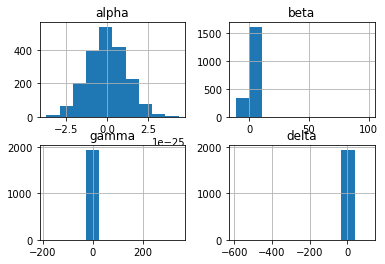

In [259]:
e_u.hist()

## Create model

In [260]:
# split data between train and test
split_point = int(len(e_u) * .8)
train = e_u.iloc[0:split_point]
test = e_u.iloc[split_point:]


states_train = states.iloc[0:split_point]
states_test = states.iloc[split_point:]

<!-- Potential alternative transformations are as follows:

* sin
* log of the Yeo-Johnson

Both of which provide a better fit than the Yeo-Johnson (as seen below).


For the rest of this notebook, we will implement the model training, forecasting, and evaluation process which will allow us to iterate over different transformations until we find one that fits our use case the best. -->

### Autogressive lag selection

In [ ]:
aic = []
for i in range(1,16):
    model = VAR(train)
    results = model.fit(i,ic='aic')
    aic.append(results.aic)
    
    
plt.figure(figsize=(10, 8))
plt.plot(aic, 'r+')
plt.legend(['AIC'])
plt.xlabel('Autocorrelation Lag')
plt.ylabel('AIC')
plt.title('Plot of sweeps over lag depths over AIC Loss functions')
plt.show()

In [ ]:
aic = []
for i in range(1,16):
    model = VARMAX(endog=train.values,exog=states_train['RedemptionPriceError'].values,initialization='approximate_diffuse')
    results = model.fit(order=(i,0))
    aic.append(results.aic)
    
    
plt.figure(figsize=(10, 8))
plt.plot(aic, 'r+')
plt.legend(['AIC'])
plt.xlabel('Autocorrelation Lag')
plt.ylabel('AIC')
plt.title('Plot of sweeps over lag depths over AIC Loss functions')
plt.show()

Given a set of candidate models for the data, **the preferred model is the one with the minimum AIC value, the sign of the data does not matter**. AIC optimizes for goodness of fit but also includes a penalty for each additional parameter, which discourages overfitting. In our case, this appears that a lag of ***9*** is optimal.


In [ ]:
# instantiate the var model object from statsmodels
model = VARMAX(endog=train.values,exog=states_train['RedemptionPriceError'].values,initialization='approximate_diffuse')

# fit model with determined lag values
results = model.fit(order=(1,0))
results.summary()

In [ ]:
Y_pred = results.forecast(exog=states_test['RedemptionPriceError'].values[0])

In [ ]:
# lag_order = results.k_ar

# Y_pred = results.forecast(train.values[-lag_order:], 1 )

In [ ]:
Y_test = test[:1]

In [ ]:
Y_test

In [ ]:
Y_pred[0]

<!-- ### Univarate model performance validation -->

In [ ]:
# sm.tools.eval_measures.rmse(Y_test['alpha'], Y_pred[:,0], axis=0)

In [ ]:
# sm.tools.eval_measures.rmse(Y_test['beta'], Y_pred[:,1], axis=0)

In [ ]:
# sm.tools.eval_measures.rmse(Y_test['gamma'], Y_pred[:,2], axis=0)

In [ ]:
# sm.tools.eval_measures.rmse(Y_test['delta'], Y_pred[:,3], axis=0)

In [ ]:
Y_pred[:,3]

In [ ]:
"{:.10}".format(float(Y_test['delta']))

## New states

## Inverse Transformations

1. $d^* = \alpha * \bar{D}$

2. $q^* = \beta *  C_{0} * C_{1} * d $

3. $r^* = \gamma * {R_{RAI}}$

4. $z^* = \delta * {R_{ETH}}$

In [ ]:
# change
Y_pred

In [ ]:
previous_state = states.iloc[train.index[-1]]

In [ ]:
d_star = Y_pred[:,0] * previous_state['globalDebtCeiling']
d_star

In [ ]:
q_star = Y_pred[:,1] * previous_state['C_o'] * previous_state['C_1'] * previous_state['d']
q_star

In [ ]:
r_star = Y_pred[:,2] * previous_state['gamma'] * previous_state['RaiInUniswap']
r_star

In [ ]:
z_star = Y_pred[:,3] * previous_state['delta'] * previous_state['EthInUniswap']
z_star

In [ ]:
last_state = states.iloc[train.index[-1]][['collateral','EthInUniswap','RaiInUniswap','RaiDrawnFromSAFEs']].to_dict()
new_state = pd.DataFrame(last_state,index=[0]) 
new_state['Q'] = new_state['collateral'] + q_star
new_state['D'] = new_state['RaiDrawnFromSAFEs'] + d_star
new_state['R_Eth'] = new_state['EthInUniswap'] + r_star
new_state['R_Rai'] = new_state['RaiInUniswap'] + z_star
print('Previous State:')
print(pd.DataFrame(last_state,index=[0]))
print('\n')
print('New State:')
new_state[['Q','R_Eth','R_Rai','D']]

## Deployment info
"Hey Andrew, it will be encapsulated by the last PSUB (not implemented yet)
we will need to implement a cadCAD policy that returns a dict with the rai_reserve, eth_reserve, rai_debt and eth_locked keys
https://github.com/BlockScience/reflexer-digital-twin/tree/master/rai_digital_twin/models/digital_twin_v1/model

The definition of the classes are on the end of https://github.com/BlockScience/reflexer-digital-twin/blob/master/rai_digital_twin/types.py

we'll be adding a UserActionParams class with all the parameters that the model requires

"
